data from https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# 데이터 준비

## 다운로드, 압축 풀기

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [3]:
!head jena_climate_2009_2016.csv

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,

## 데이터 로딩

In [ ]:
df = pd.read_csv(csv_path)

## 데이터 보기

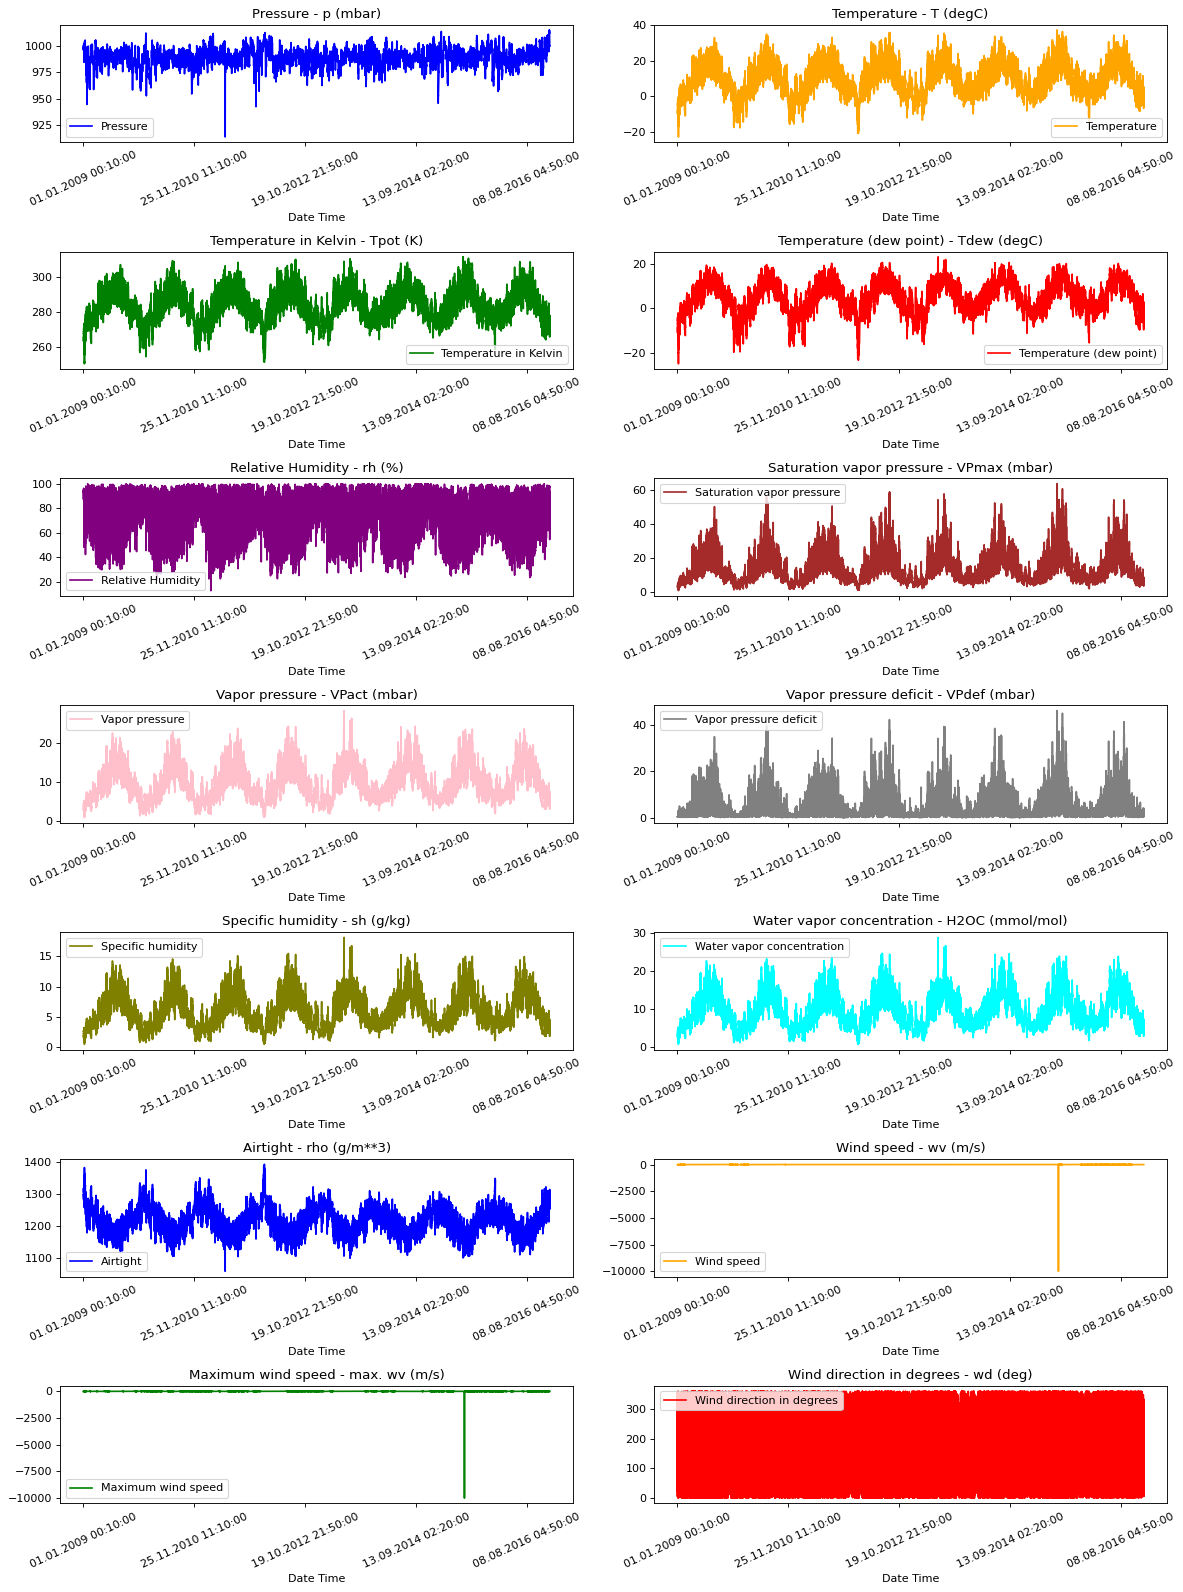

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## 컬럼 선택
전체 컬럼 중에 key feature만 추린다.

In [5]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


## standardization

In [6]:
data_mean = features.mean(axis=0)
data_std = features.std(axis=0)
features = (features - data_mean) / data_std

In [7]:
print(features.shape)

(420551, 7)


# time series generator 준비

In [8]:
WINDOW_SIZE = 720
OFFSET = 72

```
o o o o o ... o o o o o o ... o o o o
        x                     y
<---- 720 ... ---->
                    1 2 3 ... 72

```
x 데이터 1개 길이 = 720

x와 y간의 간격 = 72

offset 적용을 위한 작업

In [10]:
import numpy as np

series = features.to_numpy()
targets = features.iloc[:,1].to_numpy()
# series  : [ 0 1 2 3 4 5 6 7 8 9 ]
#             <--x-->     
# targets : [ 0 1 2 3 4 5 6 7 8 9 ]
#                         y
#                     <---> offset=3


targets = np.roll(targets, -(OFFSET-1))
# series  : [ 0 1 2 3 4 5 6 7 8 9 ]
#             <--x-->     
# targets : [ 2 3 4 5 6 7 8 9 0 1 ]
#                     y

series = series[:-(OFFSET-1)]
targets = targets[:-(OFFSET-1)]
# series  : [ 0 1 2 3 4 5 6 7 ]
#             <--x-->     
# targets : [ 2 3 4 5 6 7 8 9 ]
#                     y


In [12]:
print(series.shape)
print(targets.shape)

(420480, 7)
(420480,)


## TimeseriesGenerator 생성

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

split_index = int(len(series)*0.8)

generator = TimeseriesGenerator(series, targets, length=WINDOW_SIZE, batch_size=256, 
                                shuffle=True, end_index=split_index)

test_generator = TimeseriesGenerator(series, targets, length=WINDOW_SIZE, batch_size=256, 
                                     shuffle=True, start_index=split_index)


# 모델 정의와 학습

In [40]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

inputs = Input((WINDOW_SIZE,series.shape[1]))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 720, 7)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(generator, 
          validation_data=test_generator, 
          steps_per_epoch=len(generator)/128,
          validation_steps=len(test_generator)/128, 
          epochs=100, 
          verbose=1)

Epoch 1/100
10/10 [==============================] - 9s 707ms/step - loss: 0.8996 - val_loss: 0.4941
Epoch 2/100
10/10 [==============================] - 7s 657ms/step - loss: 0.4518 - val_loss: 0.3816
Epoch 3/100
10/10 [==============================] - 7s 656ms/step - loss: 0.3470 - val_loss: 0.3256
Epoch 4/100
10/10 [==============================] - 7s 652ms/step - loss: 0.3172 - val_loss: 0.3460
Epoch 5/100
10/10 [==============================] - 7s 652ms/step - loss: 0.2950 - val_loss: 0.2983
Epoch 6/100
10/10 [==============================] - 7s 663ms/step - loss: 0.2916 - val_loss: 0.3199
Epoch 7/100
10/10 [==============================] - 7s 676ms/step - loss: 0.2892 - val_loss: 0.3331
Epoch 8/100
10/10 [==============================] - 7s 653ms/step - loss: 0.2799 - val_loss: 0.2885
Epoch 9/100
10/10 [==============================] - 7s 659ms/step - loss: 0.2637 - val_loss: 0.2979
Epoch 10/100
10/10 [==============================] - 7s 653ms/step - loss: 0.2816 - val_lo

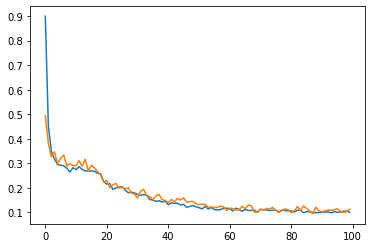

In [42]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.show()

# 결과 보기

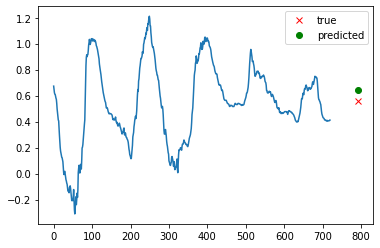

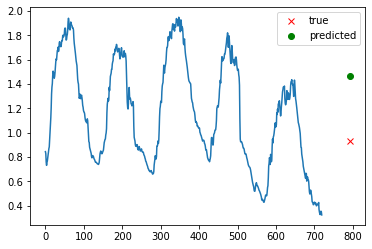

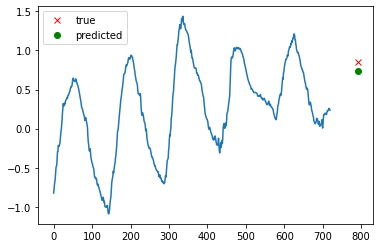

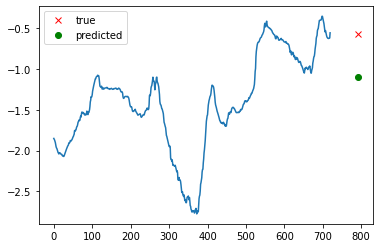

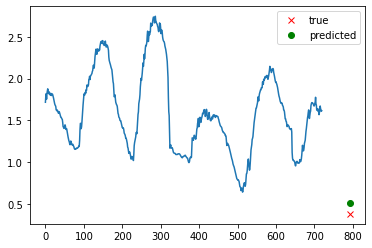

In [44]:
x, y = test_generator[0]
y_ = model.predict(x)

for i in range(5):
  plt.plot(x[i,:,1])
  plt.plot([720+72], y[i], 'rx', label="true")
  plt.plot([720+72], y_[i], 'go', label="predicted")
  plt.legend()
  plt.show()

